# Fundamentals of Data Analysis

***

## Project 2020:

### Linear Regression Analysis of the powerproduction dataset

***

This jupyter notebook contains the linear regression analysis performed by Dervla Candon on the powerproduction dataset as part of the assessment of the Fundamentals of Data Analysis module 2020.

In [1]:
# ensuring all plots will show in the notebook
%matplotlib inline

In [2]:
# for creating plots
import matplotlib.pyplot as plt
# for creating numerical arrays
import numpy as np
# for creating a dataframe with the csv data
import pandas as pd
plt.rcParams['figure.figsize'] = (9, 7)

In [3]:
# creating a dataframe with the powerproduction dataset
df = pd.read_csv("https://raw.githubusercontent.com/ianmcloughlin/2020A-machstat-project/master/dataset/powerproduction.csv")

In [4]:
# printing a summary of the dataset
df.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


## 1: Initial Assumptions

This powerproduction contains two variables; speed and power.

A given row within the dataset describes the quantity of power produced by a wind turbine for the corresponding speed measured for the wind.

Speed values range from 0 to 25 (no indication of units, however given the range I will assume the units are m/s) and the power produced ranges from 0 to 113.556. It is not possible to make a reasonable assumption of the energy units without knowing the time frame used to measure the power produced.

I will assume that the timeframe over which each power production has been measured remained constant throughout the experiment.

## 2: Simple Linear Regression on Unmodified Dataset

To begin my analysis, I will perform simple linear regression using the np.polyfit function [1], and plot this against the points from the dataset to allow for a visual comparison. 

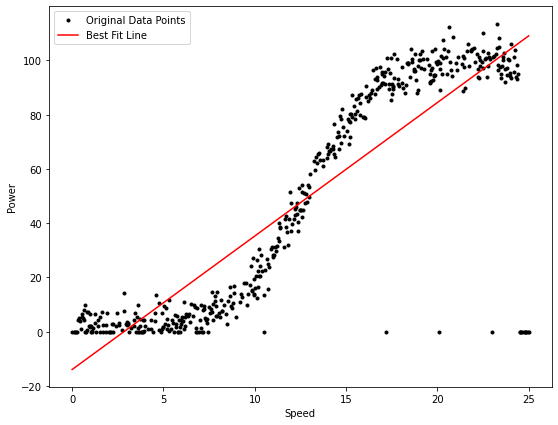

In [5]:
# np.polyfit produces two outputs, the first is the slope of the line and the second is the constant
m,c = np.polyfit(df['speed'],df['power'], 1)

# plot the individual data points to compare to the line of best fit
plt.plot(df['speed'],df['power'],'k.',label="Original Data Points")
# draw the line of best fit for the range of speed values included in the dataset
plt.plot(df['speed'],df['speed']*m + c, 'r-',label = "Best Fit Line")

# add appropriate x and y axis labels
plt.xlabel('Speed')
plt.ylabel('Power')
plt.legend()

# display the plot
plt.show()

From inspection of the above plot, it is clear that the above equation does not provide a very accurate representation of the dataset.

Initial observations are as follows:

 - the plotted datapoints do not appear to have a strong linear relationship, so it is unclear if a linear regression would best describe this relationship;
 
 - for a speed of 0m/s the plot predicts a negative value for speed, which is not a possible or useful prediction in a real-world scenario
 
 - while there appear to be some isolated data points which return a zero power value for speeds between 10m/s and 24m/s, there also appears to be a cluster of values grouped around the 25m/s speed with zero power production.

In [6]:
# this lambda cost function has been obtained from the linear regression lecture [2]
cost = lambda m,c: np.sum([(df['power'][i] - m * df['speed'][i] - c)**2 for i in range(df['speed'].size)])
print(f"The cost of the best fit line with no adjustments is {cost(m,c)}")

The cost of the best fit line with no adjustments is 234241.1641532122


The above calculation of the cost of the best fit line - based on the content covered in topic 9 of the lectures [2] - reaffirms my initial impression that this best fit line is not an accurate representation of the dataset.

In the remainder of this jupyter notebook, I will investigate if there exists a better linear equation to represent this dataset (better implying a lower cost), or if in fact there exists a non-linear relationship which better describes the relationship betwqeen wind speeds and wind turbine power production.

## 3: Outlier, Yes or No?

As briefly touched on previously, I have identified two potential groups of outliers in the dataset.

For the first group, there are 4 isolated points for which a wind speed value between 10m/s and 24m/s returns a zero power value. For each of these speed values, the graph identifies numerous data points with equal or near-equal speeds that have a non-zero power production. The combination of these two factors leads me to conclude that these factors are indeed outliers, which do not provide accurate representations of the speed/power relationship I am investigating.

The second group contains numerous datapoints which, while the are not closely grouped with the majority of the data points from the data set, are closely clustered to one another. If there are a number of experiments which produced the same output value, can they all be considered outliers? An additional cause for concern is that for these speed values, grouped closely around 25m/s, there are no other data points recorded which are grouped closely to the datapoints for lower speed values.

Given these values in question fall at the upper bound of the dataset, I have investigated the limitations of wind turbines. As it happens, wind turbines are designed to cease operating once wind speeds reach a certain speed, applying brakes on the propellers to ensure that they are not damaged by excessive wind speeds. For most large wind turbines, the speed at which the turbines stop power production is 55mph [3], which corresponds to approximately 24.6 m/s.

As such, this second group of data points are not outliers, but representations of the real-world operation of a wind turbine.

If a full spectrum of non-zero x values are being considered as the domain of the function, then the function should be split into 2 variations; 

 - 0 for all x >= 24.6m/s
 
 - TBD for x < 24.6m/s
 
Once I have confirmed this value of 24.6m/s as an accurate cut off point based on the dataset, I will remove all values for higher speeds for my remaining analysis.

In [7]:
# show all values with a zero power output
df.loc[df['power'] == 0,'speed']

0       0.000
1       0.125
2       0.150
3       0.225
4       0.275
15      0.726
16      0.751
24      1.026
26      1.076
31      1.301
35      1.552
37      1.677
39      1.827
42      2.027
43      2.077
44      2.102
47      2.252
60      3.128
65      3.504
67      3.579
70      3.679
73      3.779
74      3.804
75      3.879
83      4.429
89      4.880
105     5.556
110     5.781
111     5.806
114     5.931
133     6.782
135     6.857
136     6.957
140     7.107
149     7.432
208    10.511
340    17.167
404    20.095
456    22.998
490    24.499
491    24.525
492    24.575
493    24.650
494    24.750
495    24.775
496    24.850
497    24.875
498    24.950
499    25.000
Name: speed, dtype: float64

As seen in the above results, rows 0 to 456 inclusive with a zero power production correspond to either the first group of outliers I have identified (rows 208, 340, 404, and 456) or points which have a lower wind speed value and do not appear as outliers on the plot.

Going by the speed values for the remaining zero power production values, 24.499 appears to be the most appropriate cut off point for the domain of the regression equation. As seen by the consecutive row numbers from 490-500 appearing above, there are no non-zero values falling above a speed of 24.499m/s

As a result, I will remove the rows which contain zero power values for all rows after and including row 208, which will remove both the outlier data points and those which do not correspond to a moving wind turbine.

In [8]:
# create a new dataframe in variable data for the remaining analysis
data = df.drop([208,340,404,456,490,491,492,493,494,495,496,497,498,499], axis=0)
data.reset_index(inplace=True)
# print data to screen
data

,index,speed,power
0,0,0.000,0.000
1,1,0.125,0.000
2,2,0.150,0.000
3,3,0.225,0.000
4,4,0.275,0.000
...,...,...,...
481,485,24.249,103.700
482,486,24.299,93.694
483,487,24.349,93.078
484,488,24.374,98.223


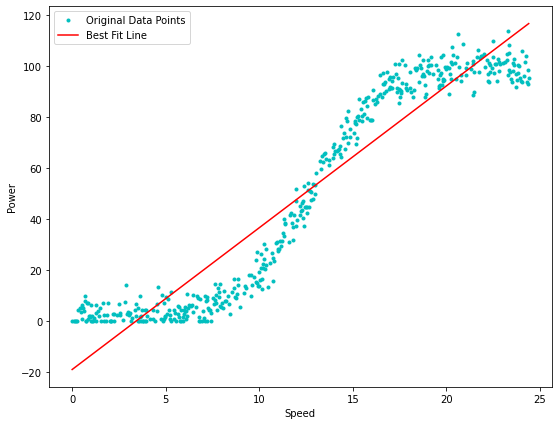

In [9]:
# repeat the linear polyfit for the new dataset
m2,c2 = np.polyfit(data['speed'],data['power'], 1)

plt.plot(data['speed'],data['power'],'c.',label="Original Data Points")
plt.plot(data['speed'],data['speed']*m2 + c2, 'r-',label = "Best Fit Line")

plt.xlabel('Speed')
plt.ylabel('Power')
plt.legend()

plt.show()

In [10]:
cost2 = lambda m,c: np.sum([(data['power'][i] - m * data['speed'][i] - c)**2 for i in range(data['speed'].size)])
print(f"The cost of the best fit line with outliers removed and adjusted domain is {cost2(m2,c2)}")
#data

The cost of the best fit line with outliers removed and adjusted domain is 80977.02805039407


In [11]:
print(f"This adjusted linear regression has a cost of {round((cost2(m2,c2)/cost(m,c))*100,2)}% of the unadjusted linear regression")

This adjusted linear regression has a cost of 34.57% of the unadjusted linear regression


By removing the outliers of the data set the cost of the linear best fit line is almost reduced to 1/3 of the cost of the initial best fit line.

***

## 4: Linear or Non-Linear?

The np.polyfit takes in three parameters; x-values, y-values, and degree of the function. For both best fit lines thus far, a degree of 1 has been used, which corresponds to a linear relationship, or a straight line. 

However, when you look at the data points plotted from the dataset, they appear to have a curved trend rather than a linear. Thus I will investigate, using the adjusted dataset, the appearance and cost of a quadratic and cubic equation to describe the relationship between the variables.

***

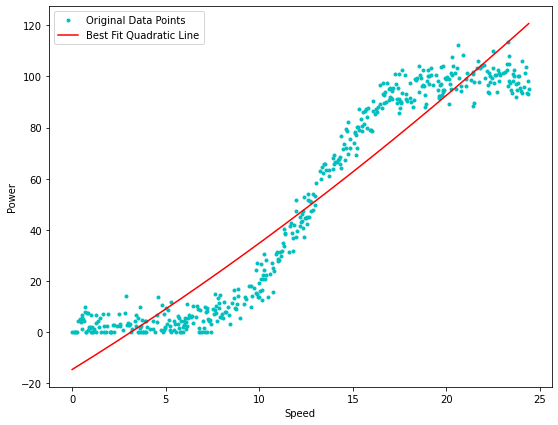

In [16]:
# a quadratic polyfit will return 3 variables
a3, b3, c3 = np.polyfit(data['speed'],data['power'], 2)


plt.plot(data['speed'],data['power'],'c.',label="Original Data Points")
plt.plot(data['speed'],a3 * (data['speed']**2) + b3 * data['speed'] + c3, 'r-',label = "Best Fit Quadratic Line")

plt.xlabel('Speed')
plt.ylabel('Power')
plt.legend()

plt.show()

In [20]:
# new cost function defined for quadratic lines
quadratic_cost = lambda a,b,c: np.sum([(data['power'][i] - a * (data['speed'][i]**2) - b * data['speed'][i] - c)**2 for i in range(data['speed'].size)])
print(f"The cost of the best fit quadratic line is {quadratic_cost(a3,b3,c3)}")

The cost of the best fit quadratic line is 79243.70337587869


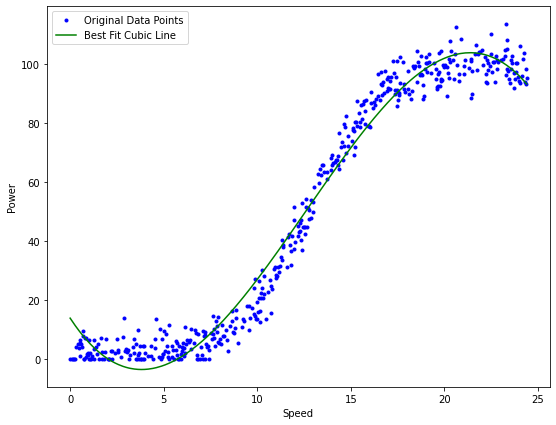

In [21]:
# a cubic equation outputs 4 variables
a4, b4, c4, d4 = np.polyfit(data['speed'],data['power'], 3)


plt.plot(data['speed'],data['power'],'b.',label="Original Data Points")
plt.plot(data['speed'],a4 * (data['speed']**3) + b4 * (data['speed']**2) + c4 * data['speed'] + d4, 'g-',label = "Best Fit Cubic Line")

plt.xlabel('Speed')
plt.ylabel('Power')
plt.legend()

plt.show()

In [22]:
# new cost function defined for cubic lines
cubic_cost = lambda a,b,c,d: np.sum([(data['power'][i] - a * (data['speed'][i]**3) - b * (data['speed'][i]**2) - c * data['speed'][i] - d)**2 for i in range(data['speed'].size)])
print(f"The cost of the best fit cubic line is {cubic_cost(a4,b4,c4,d4)}")

The cost of the best fit cubic line is 17556.81440073272


## 5: Expected Relationship

As shown by the results of each cost function calculated, the cubic line has the lowest cost, and as such is the bestr representation of the relationship between wind speed and power.

In general, The relationship between wind speed *V* and power produced *P* can be described as follows [3]:

$$\ P = C_p k V^3 $$

Where k represents a constant number in this experiment, which depends on air density and rotor size, and $\ C_p $ is the power coefficient [4]. This equation describes a cubic relationship between *P* and *V*, which supports the analysis thus far that a cubic regression is more appropriate than a linear or quadratic one.

##### References

[1] numpy.polyfit; NumPy; https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

[2] Linear Regression; Ian McLoughlin; https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/simple-linear-regression.ipynb

[3] How to calculate power output of wind; windpowerengineering; https://www.windpowerengineering.com/calculate-wind-power-output/

[4] Wind Power Coefficient; David E. Watson; https://www.ftexploring.com/wind-energy/wind-power-coefficient.htm

<br>

***

# End

***